In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import nltk
import string

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.utils import shuffle

from sklearn.manifold import TSNE

In [2]:
#defining all the required functions here
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

def cleanHTML(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanPunctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'', sentence)
    return cleaned


#removing stop words
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initializing the Snowball Stemmer

final_dataset_path = '/home/monodeepdas112/Datasets/amazon-fine-food-reviews/final.sqlite'
initial_dataset_path = '/home/monodeepdas112/Datasets/amazon-fine-food-reviews/database.sqlite'

In [3]:
if os.path.isfile(final_dataset_path):
    #loading the cleaned dataset if present
    con = sqlite3.connect(final_dataset_path)
    data = pd.read_sql_query('select * from Reviews', con)
    
    with open('positive_words.pkl', 'rb') as f:
        all_positive_words = pickle.load(f)
    with open('negitive_words.pkl', 'rb') as f:
        all_negative_words = pickle.load(f)
else:
    #cleaning the dataset and making the finally cleaned dataset if the cleaned dataset is not present
    con = sqlite3.connect(initial_dataset_path)
    filtered_data = pd.read_sql_query('select * from Reviews where score != 3', con)
    
    #replacing the score column to contain only positive or negative rather than continuous range of values
    actualScore = filtered_data['Score']
    positiveNegativeScore = actualScore.map(partition)
    filtered_data['Score'] = positiveNegativeScore
    
    #data deduplication
    sorted_data = filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
    
    #removing some wrong data points
    data = data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
    
    #text pre-processing
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(data['Text'].values)):
        filtered_sentence=[]
        sent = cleanHTML(sent)#removing HTML tags
        for w in sent.split():
            for cleaned_words in cleanPunctuation(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower()))
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive':
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = ' '.join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
    
    #############---- storing the data into final.sqlite file ------########################
    data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    data['CleanedText']=final['CleanedText']
    
    conn = sqlite3.connect(final_dataset_path)
    c=conn.cursor()
    conn.text_factory = str
    data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    #saving the dictionaries
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [4]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month learn poem throug...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [5]:
min_data_points = 1000

In [6]:
pos_data = data[data.Score=='positive'].loc[:, ['CleanedText', 'Score']]
pos_data = pos_data.sample(min_data_points)
neg_data = data[data.Score=='negative'].loc[:, ['CleanedText', 'Score']]
neg_data = neg_data.sample(min_data_points)
part_data = pos_data.append(neg_data)
part_data = shuffle(part_data)

cleaned_text = part_data['CleanedText'].tolist()

In [7]:
#Function to plot t-SNE
def plot_t_SNE(features, labels):
    plt.figure(figsize=(25, 25))
    ind=1
    for p in range(1, 61, 20):
        for i in range(1000, 5001, 1000):
            #defining the t-SNE model
            model = TSNE(n_components=2, random_state=0, perplexity=p, n_iter=i)
            tsne_data = model.fit_transform(features)
            
            #creating a new dataframe which help in plotting the result data
            tsne_data = np.vstack((tsne_data.T, labels)).T
            tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))
            
            pos = tsne_df[tsne_df.label=='positive']
            neg = tsne_df[tsne_df.label=='negative']
            
            #Plotting the t-sne plot
            plt.subplot(5, 5, ind)
            plt.scatter(pos.iloc[:,0], pos.iloc[:,1], c='r')
            plt.scatter(neg.iloc[:,0], neg.iloc[:,1], c='b')
            plt.title('Perplexity : {0} Iterations : {1}'.format(p, i))
            ind=ind+1
    plt.show()
    
list_of_sentences=[]
for sentence in cleaned_text:
    list_of_sentences.append(sentence.split())
    
#Training my own Word2Vec model
w2v_model=Word2Vec(list_of_sentences, size=50, workers=4)

## t-SNE with Word2Vec

100%|██████████| 2000/2000 [00:01<00:00, 1962.76it/s]


2000
50


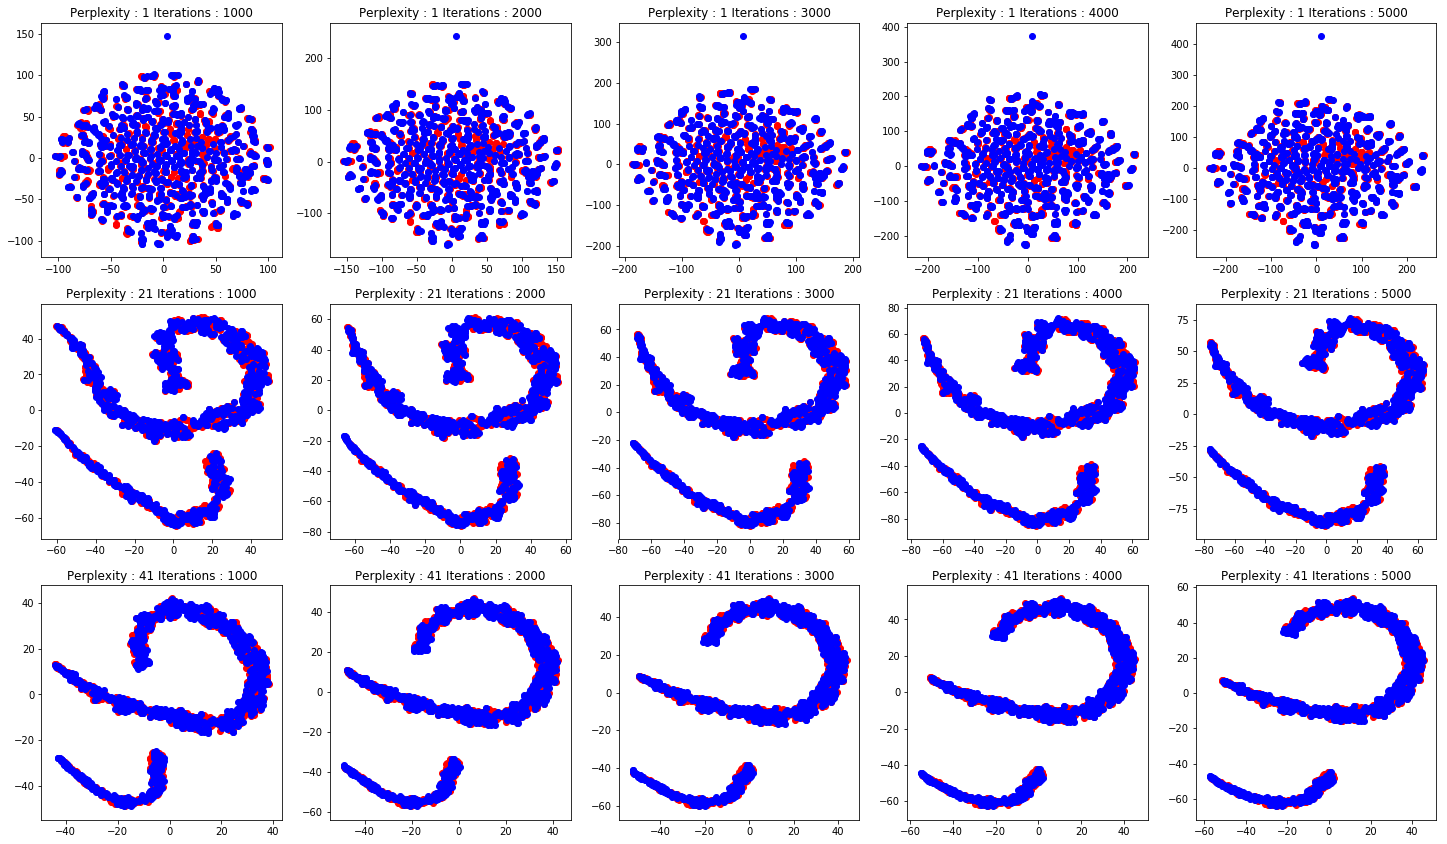

In [8]:
#Making the sentence vectors
sent_vectors = []
for sent in tqdm(list_of_sentences):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_model:
            word_vec = w2v_model.wv[word]
            sent_vec += word_vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

#setting up t-SNE using Average Word2Vec
features = sent_vectors
labels = part_data['Score'].values
#plotting t-SNE
plot_t_SNE(features, labels)

## t-SNE with Bag of Words

the shape of out text BOW vectorizer  (2000, 1000)
the number of unique words  1000


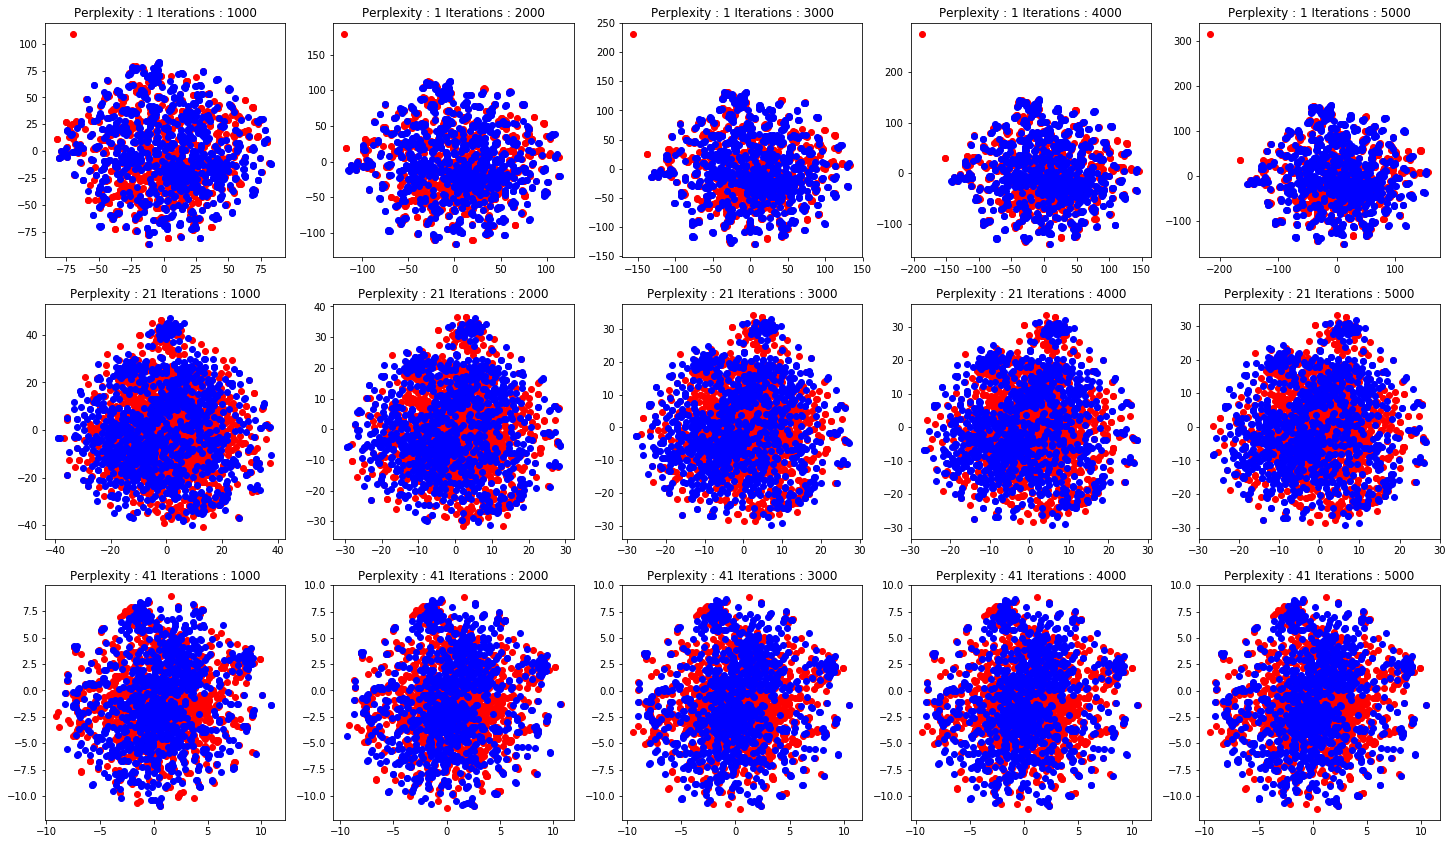

In [9]:
#Generating the Count Vectors for the cleaned Text with bi-grams and unigrams
cnt_vec = CountVectorizer(ngram_range=(1,3), max_features=1000)
count_vectors = cnt_vec.fit_transform(cleaned_text)
print("the shape of out text BOW vectorizer ",count_vectors.get_shape())
print("the number of unique words ", count_vectors.get_shape()[1])

#setting up t-SNE using BOW
features = count_vectors.toarray()
labels = part_data['Score'].values

plot_t_SNE(features, labels)

## t-SNE with TF-IDF

the shape of out text TFIDF vectorizer  (2000, 1000)
the number of unique words  1000


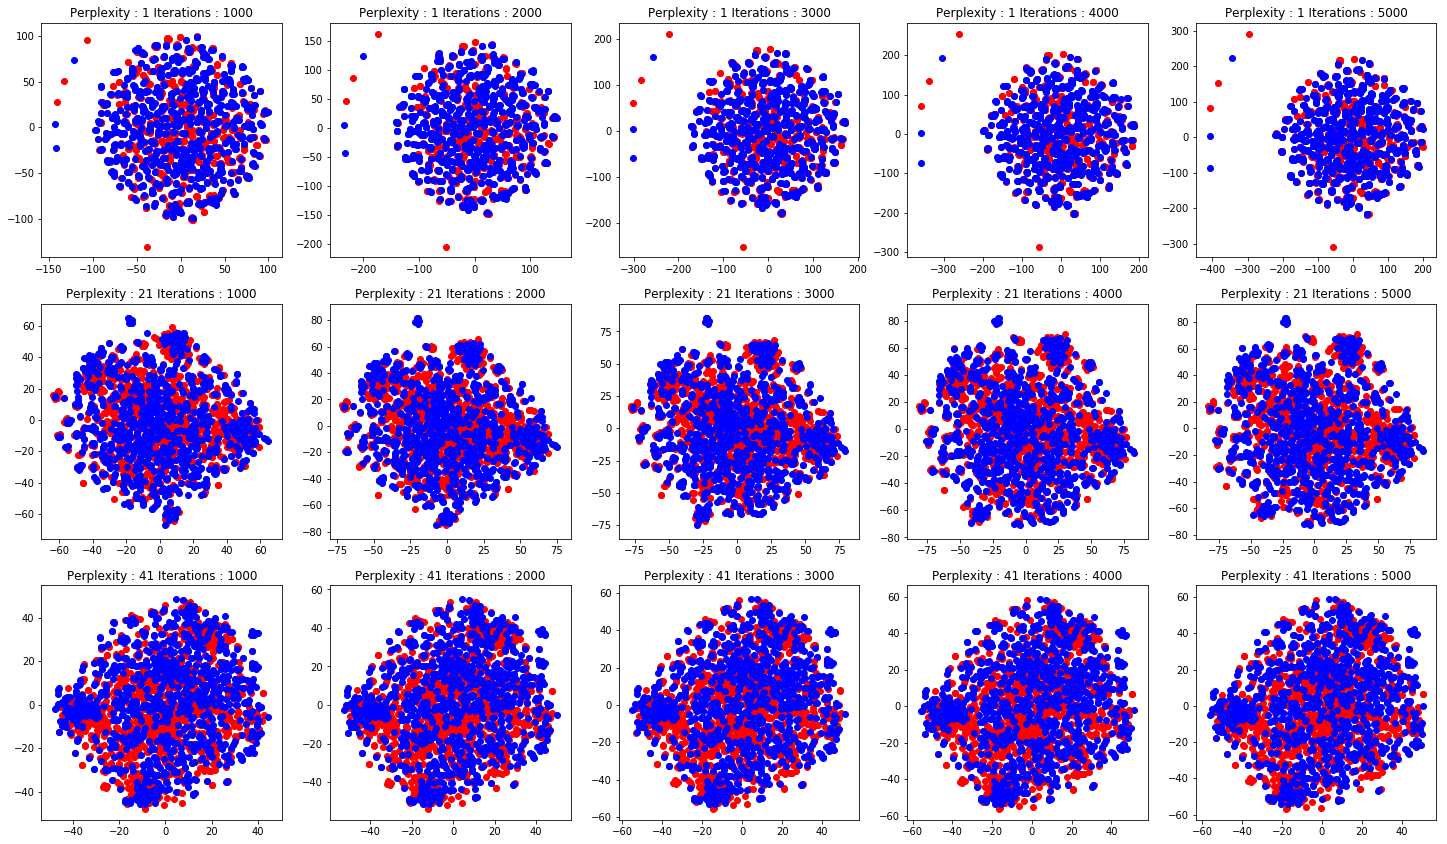

In [10]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), max_features=1000)
tfidf_vectors = tfidf_vec.fit_transform(cleaned_text)
print("the shape of out text TFIDF vectorizer ",count_vectors.get_shape())
print("the number of unique words ", count_vectors.get_shape()[1])

#setting up t-SNE using TFIDF
features = tfidf_vectors.toarray()
labels = part_data['Score'].values

plot_t_SNE(features, labels)

## t-SNE with TF-IDF weighted Word2Vec

100%|██████████| 2000/2000 [00:02<00:00, 962.75it/s]


2000
50


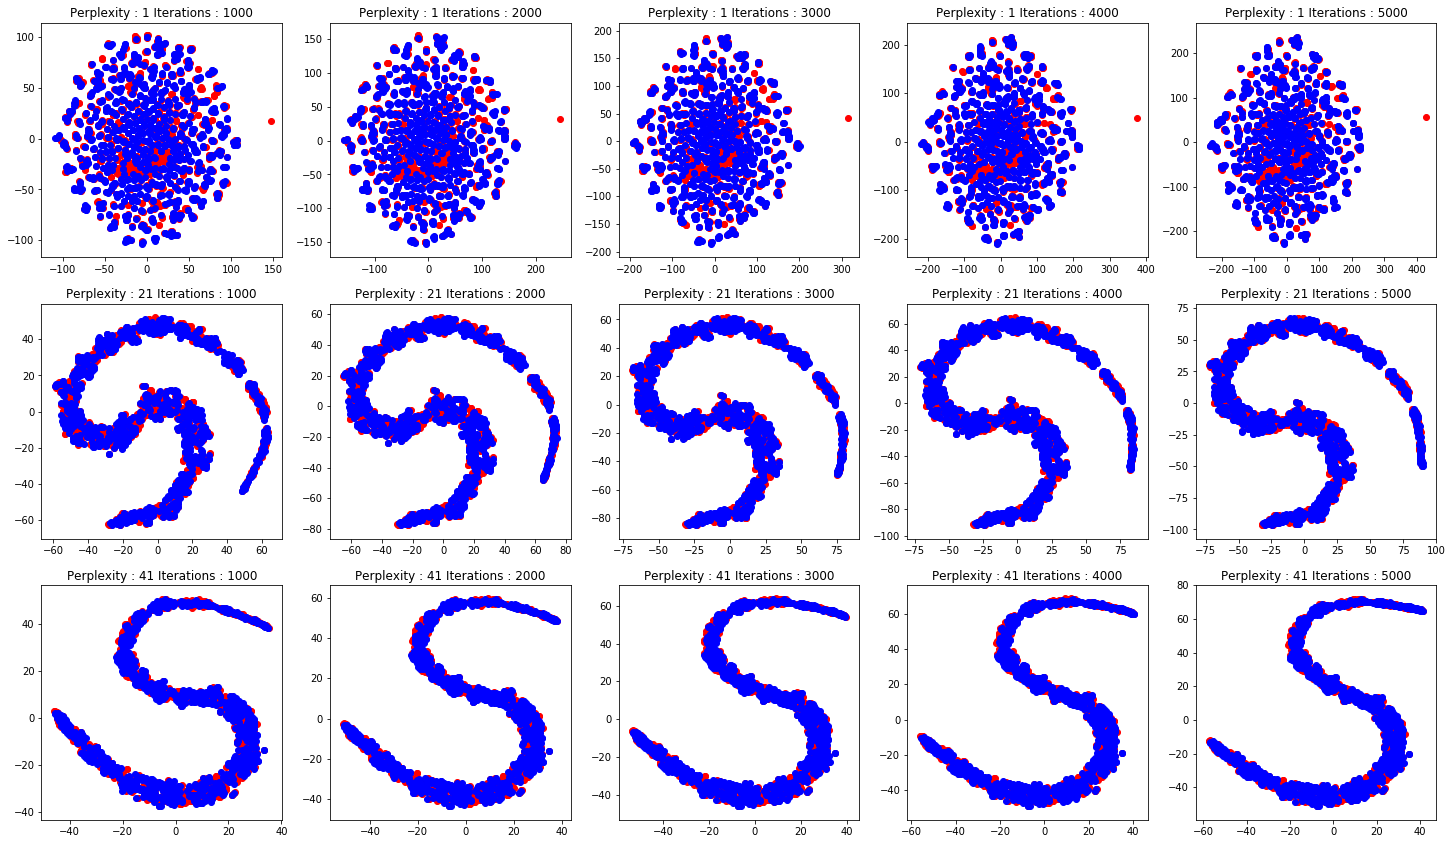

In [11]:
#initializing tf-idf model with ngram_range = (1,3)
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), max_features=1000)
tfidf_vec.fit_transform(cleaned_text)

#creating a dictionary of idf values
idf_dictionary = dict(zip(tfidf_vec.get_feature_names(), list(tfidf_vec.idf_)))
#getting the names of the features
tfidf_features = tfidf_vec.get_feature_names()

#creating the features
tfidf_sent_vectors = [];
row=0;
for sent in tqdm(list_of_sentences): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model and word in tfidf_features:
            vec = w2v_model.wv[word]
            tf_idf = idf_dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

features = tfidf_sent_vectors
labels = part_data['Score'].values

plot_t_SNE(features, labels)

## Conclusion

I had to limit the max_features to 1000 and use 1000 data pts and had to refer from assignment 3 to optimize the performance of Tf-Idf vectorizer to use the dictionary approach for idf features.
But when I was trying to multiply TF-IDF Vectors with W2V then I was getting the error as Dimentionality Mismatch which is logical though as both are having different lengths. So Please tell me what should be done about it ??